## 违约预测（LR + RF + XGBoost + LightGBM）


In [7]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# 读取清洗后数据（由 data_prepare.ipynb 导出）
DATA_DIR = Path("../data")
df = pd.read_csv(DATA_DIR / "loan_clean.csv", low_memory=False)
if "is_default" not in df.columns and "loan_status" in df.columns:
    BAD_STATUS = ["Charged Off", "Default", "Late (31-120 days)", "Late (16-30 days)", "In Grace Period"]
    df["is_default"] = df["loan_status"].isin(BAD_STATUS).astype(int)
if "term_months" not in df.columns and "term" in df.columns:
    df["term_months"] = pd.to_numeric(df["term"].astype(str).str.extract(r"(\\d+)", expand=False), errors="coerce")

# 使用清洗后的 df（无缺失行）
ml_df = df.copy()

# 数值特征
num_cols = [
    "int_rate", "dti", "loan_amnt", "funded_amnt", "installment",
    "delinq_2yrs", "mths_since_last_delinq", "revol_util", "open_acc", "total_acc",
    "inq_last_6mths", "annual_inc", "term_months", "revol_bal"
]
num_cols = [c for c in num_cols if c in ml_df.columns]

# 分类特征（One-Hot）
cat_cols = ["grade", "purpose", "home_ownership"]
cat_cols = [c for c in cat_cols if c in ml_df.columns]
X_cat = pd.get_dummies(ml_df[cat_cols], drop_first=True, dtype=float)

X_num = ml_df[num_cols].fillna(0)
X = pd.concat([X_num.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)
y = ml_df["is_default"].values

# 划分
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# 标准化（树模型可不做，为 Logistic 做）
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
print("特征维度:", X.shape[1], "| 训练:", len(X_train), "| 测试:", len(X_test), "| 违约率:", round(float(y.mean()), 4))

特征维度: 34 | 训练: 134384 | 测试: 33597 | 违约率: 0.0118


**数据与样本解读：**

- **特征维度 34**：由数值特征（利率、DTI、金额、还款、逾期、收入等）与分类特征（grade、purpose、home_ownership 的 One-Hot）组成，覆盖了信用定价、还款能力、历史行为等风控常用维度。
- **训练 134384 / 测试 33597**：按 8:2 划分且 `stratify=y`，保证训练/测试集中违约比例一致，评估更可靠。
- **违约率约 1.18%**：典型**高度不平衡**场景。**不能只看准确率，需关注精确率/召回率/F1 和 AUC**，必要时用 `class_weight='balanced'` 或过采样/欠采样。

### 2. 训练模型

- **Logistic Regression**：可解释性好，适合风控汇报
- **Random Forest**：非线性、特征重要性直观
- **XGBoost / LightGBM**：梯度提升树，表格数据常用，不平衡时用 `scale_pos_weight`

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression（用标准化后的特征）
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
lr.fit(X_train_s, y_train)
y_pred_lr = lr.predict(X_test_s)
y_proba_lr = lr.predict_proba(X_test_s)[:, 1]

# Random Forest（用原始特征即可）
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

In [15]:
# XGBoost / LightGBM（树模型用未标准化特征；不平衡用 scale_pos_weight）
import numpy as np
scale_pos = (y_train == 0).sum() / max((y_train == 1).sum(), 1)

try:
    import xgboost as xgb
    xgb_clf = xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42, use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale_pos)
    xgb_clf.fit(X_train, y_train)
    y_pred_xgb = xgb_clf.predict(X_test)
    y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
    HAS_XGB = True
except Exception as e:
    HAS_XGB = False
    print("XGBoost 未安装或报错:", e)

try:
    import lightgbm as lgb
    lgb_clf = lgb.LGBMClassifier(n_estimators=100, max_depth=6, random_state=42, verbose=-1, scale_pos_weight=scale_pos)
    lgb_clf.fit(X_train, y_train)
    y_pred_lgb = lgb_clf.predict(X_test)
    y_proba_lgb = lgb_clf.predict_proba(X_test)[:, 1]
    HAS_LGB = True
except Exception as e:
    HAS_LGB = False
    print("LightGBM 未安装或报错:", e)

### 3. 评估指标：准确率、精确率、召回率、AUC-ROC 曲线

用以下四项评估模型：**准确率（Accuracy）**、**精确率（Precision）**、**召回率（Recall）**、**AUC-ROC**；ROC 曲线见本节后图。

In [16]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)
from sklearn.metrics import roc_curve as _roc_curve

def ks_score(y_true, y_proba):
    """KS = max |TPR - FPR|，风控常用区分度指标。"""
    fpr, tpr, _ = _roc_curve(y_true, y_proba)
    return float(np.max(np.abs(tpr - fpr)))

def print_metrics(name, y_true, y_pred, y_proba=None):
    print(f"--- {name} ---")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("Precision:", round(precision_score(y_true, y_pred, zero_division=0), 4))
    print("Recall:", round(recall_score(y_true, y_pred, zero_division=0), 4))
    print("F1:", round(f1_score(y_true, y_pred, zero_division=0), 4))
    if y_proba is not None:
        print("ROC-AUC:", round(roc_auc_score(y_true, y_proba), 4))
        print("KS:", round(ks_score(y_true, y_proba), 4))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print()

print_metrics("Logistic Regression", y_test, y_pred_lr, y_proba_lr)
print_metrics("Random Forest", y_test, y_pred_rf, y_proba_rf)
try:
    if HAS_XGB:
        print_metrics("XGBoost", y_test, y_pred_xgb, y_proba_xgb)
except NameError:
    pass
try:
    if HAS_LGB:
        print_metrics("LightGBM", y_test, y_pred_lgb, y_proba_lgb)
except NameError:
    pass

# 汇总：准确率、精确率、召回率、AUC-ROC、KS（含 XGB/LGB 若已训练）
models = [("Logistic Regression", y_pred_lr, y_proba_lr), ("Random Forest", y_pred_rf, y_proba_rf)]
try:
    if HAS_XGB:
        models.append(("XGBoost", y_pred_xgb, y_proba_xgb))
except NameError:
    pass
try:
    if HAS_LGB:
        models.append(("LightGBM", y_pred_lgb, y_proba_lgb))
except NameError:
    pass
eval_summary = pd.DataFrame({
    "模型": [m[0] for m in models],
    "准确率": [round(accuracy_score(y_test, m[1]), 4) for m in models],
    "精确率": [round(precision_score(y_test, m[1], zero_division=0), 4) for m in models],
    "召回率": [round(recall_score(y_test, m[1], zero_division=0), 4) for m in models],
    "AUC-ROC": [round(roc_auc_score(y_test, m[2]), 4) for m in models],
    "KS": [round(ks_score(y_test, m[2]), 4) for m in models],
})
eval_summary

--- Logistic Regression ---
Accuracy: 0.6468
Precision: 0.0223
Recall: 0.6785
F1: 0.0432
ROC-AUC: 0.7164
KS: 0.3253
Confusion Matrix:
 [[21463 11739]
 [  127   268]]

--- Random Forest ---
Accuracy: 0.8252
Precision: 0.0223
Recall: 0.3241
F1: 0.0418
ROC-AUC: 0.6889
KS: 0.3112
Confusion Matrix:
 [[27595  5607]
 [  267   128]]

--- XGBoost ---
Accuracy: 0.8921
Precision: 0.0222
Recall: 0.1899
F1: 0.0397
ROC-AUC: 0.6099
KS: 0.1831
Confusion Matrix:
 [[29898  3304]
 [  320    75]]

--- LightGBM ---
Accuracy: 0.7542
Precision: 0.022
Recall: 0.4582
F1: 0.042
ROC-AUC: 0.6568
KS: 0.2444
Confusion Matrix:
 [[25158  8044]
 [  214   181]]



,模型,准确率,精确率,召回率,AUC-ROC,KS
0,Logistic Regression,0.6468,0.0223,0.6785,0.7164,0.3253
1,Random Forest,0.8252,0.0223,0.3241,0.6889,0.3112
2,XGBoost,0.8921,0.0222,0.1899,0.6099,0.1831
3,LightGBM,0.7542,0.0220,0.4582,0.6568,0.2444


- **准确率**：XGB 最高（约 89.2%），其次 RF（82.5%）、LGB（75.4%）、LR（64.7%）；但因违约率仅 1.18%，把所有人都判为"不违约"准确率也有约 98.8%，故**不能单独用准确率衡量**。
- **精确率**：四模型均约 2.2%～2.23%，即预测为"违约"的样本里真正违约的很少，**误报多**。在风控中可对应"拦截了多少笔、其中多少是误伤"，需结合业务成本与阈值权衡。
- **召回率**：LR 最高（约 67.9%），其次 LGB（45.8%）、RF（32.4%）、XGB（19.0%）；LR 更能**找出真正的违约客户**，XGB 最保守、漏掉更多违约。
- **AUC-ROC**：LR（0.716）> RF（0.689）> LGB（0.657）> XGB（0.610），在**排序能力**上 LR 最好，XGB 在本样本/设定下相对较弱。
- **KS**：LR（0.325）、RF（0.311）达常见风控要求 KS>0.3 的区分度；LGB（0.244）、XGB（0.183）略低。若业务更怕"漏掉违约"可优先选 **LR**（召回与 KS 均优），更怕"误拒好人"可提高阈值或选更保守模型。
- **在极度不平衡下，AUC 与 KS 比单一阈值下的准确率/精确率/召回率更稳定，适合做模型对比与阈值选择。**


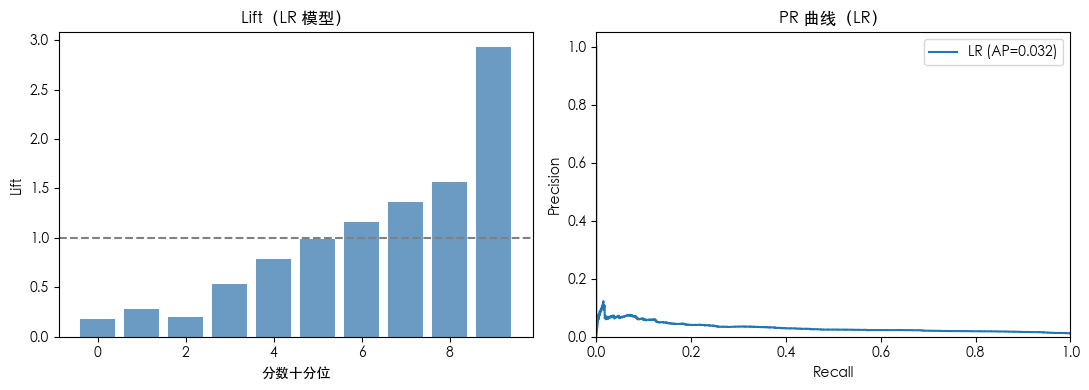

表1 — Lift 分档


,分档,命中率,样本数,lift
0,1,0.0021,3360,0.1772
1,2,0.0033,3360,0.2785
2,3,0.0024,3359,0.2026
3,4,0.0062,3360,0.5316
4,5,0.0092,3360,0.7847
5,6,0.0116,3359,0.9875
6,7,0.0137,3360,1.1645
7,8,0.0161,3359,1.3674
8,9,0.0185,3360,1.5695
9,10,0.0345,3360,2.9364


表2 — 不同阈值下的 Precision / Recall（LR）


,阈值,Precision,Recall
0,0.01,0.0118,1.0000
1,0.02,0.0118,1.0000
2,0.05,0.0118,1.0000
3,0.10,0.0118,1.0000
4,0.20,0.0123,0.9899
5,0.50,0.0223,0.6785


In [23]:
# Lift：按分数十分位，每档命中率 / 全局正样本率
import matplotlib.pyplot as plt
def lift_curve(y_true, y_proba, n_bins=10):
    df = pd.DataFrame({"y": y_true, "p": y_proba})
    df["bin"] = pd.qcut(df["p"], n_bins, labels=False, duplicates="drop")
    global_rate = df["y"].mean()
    lift = df.groupby("bin")["y"].agg(["mean", "count"]).assign(lift=lambda x: x["mean"] / max(global_rate, 1e-6))
    return lift

# 以 LR 为例画 Lift 与 PR，并打印 2 个表格
fig, axes = plt.subplots(1, 2, figsize=(11, 4))
# Lift（取前 10 档）
lift_df = lift_curve(y_test, y_proba_lr, 10)
axes[0].bar(range(len(lift_df)), lift_df["lift"], color="steelblue", alpha=0.8)
axes[0].axhline(y=1, color="gray", linestyle="--")
axes[0].set_xlabel("分数十分位")
axes[0].set_ylabel("Lift")
axes[0].set_title("Lift（LR 模型）")
# PR 曲线
prec, rec, thresh = precision_recall_curve(y_test, y_proba_lr)
ap = average_precision_score(y_test, y_proba_lr)
axes[1].plot(rec, prec, label=f"LR (AP={ap:.3f})")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("PR 曲线（LR）")
axes[1].legend()
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1.05)
plt.tight_layout()
plt.show()

# 表1：Lift 分档（分档、命中率、样本数、Lift）
lift_display = lift_df.reset_index().rename(columns={"mean": "命中率", "count": "样本数"})
lift_display.insert(0, "分档", range(1, len(lift_display) + 1))
print("表1 — Lift 分档")
display(lift_display[["分档", "命中率", "样本数", "lift"]].round(4))

# 表2：不同阈值下的 Precision / Recall（LR）
thresh_vals = [0.01, 0.02, 0.05, 0.10, 0.20, 0.50]
rows = []
for t in thresh_vals:
    pred_t = (y_proba_lr >= t).astype(int)
    rows.append({
        "阈值": t,
        "Precision": round(precision_score(y_test, pred_t, zero_division=0), 4),
        "Recall": round(recall_score(y_test, pred_t, zero_division=0), 4),
    })
threshold_df = pd.DataFrame(rows)
print("表2 — 不同阈值下的 Precision / Recall（LR）")
display(threshold_df)

**表1（Lift 分档）解读**：分档 1 为分数最低的 10% 客户，命中率约 0.21%、Lift 约 0.18，违约率低于整体，说明低分档相对更“安全”；分档 10 为分数最高的 10%，命中率约 3.45%、Lift 约 2.94，即该档违约率约为整体的 2.94 倍。随分档升高，命中率与 Lift 整体呈上升趋势，说明模型**排序有效**——高分档集中了更多违约客户，可用于优先催收或重点审批。

**表2（阈值–Precision/Recall）解读**：阈值 0.01～0.10 时 Recall=1，几乎抓住全部违约，但 Precision 仅约 1.18%，误报很多；阈值 0.50 时 Precision 约 2.23%、Recall 约 67.85%，为默认阈值下的召回–精确权衡。业务上：若更怕漏掉违约（如首贷严控），可选用较低阈值以提高召回；若更怕误伤好人，可提高阈值以提高精确率。

### 3.2 不平衡处理说明

本项目采用：**划分** `stratify=y`；**LR/RF** 使用 `class_weight='balanced'`；**XGB/LGB** 使用 `scale_pos_weight=负样本数/正样本数`，在损失中提高少数类权重。未使用 SMOTE；可按业务需求调节分类阈值（如提高召回时降低阈值），或扩展 SMOTE（仅在训练集使用）。详见 `docs/feat.md` 与 `docs/interview_enhancement.md`。

### 4. 特征重要性（Random Forest）

In [18]:
# Random Forest 特征重要性
imp = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)
imp.head(15)

,feature,importance
0,int_rate,0.210351
13,revol_bal,0.078385
1,dti,0.073950
4,installment,0.066220
7,revol_util,0.063363
11,annual_inc,0.058797
16,grade_D,0.051113
2,loan_amnt,0.046977
9,total_acc,0.045237
8,open_acc,0.044979


**特征重要性·业务解读**：Top 特征与风控直觉一致——**int_rate** 高多为风险定价高、资质差；**revol_util / dti** 高表示偿债压力大；**revol_bal / installment** 高则还款负担重；**grade_D/E** 为信用等级差；**delinq_2yrs / mths_since_last_delinq** 直接反映历史逾期行为。可据此做准入与定价建议；可选 SHAP 单样本解释（见 `docs/interview_enhancement.md`）。



- **int_rate（利率）** 重要性最高（约 21%）：定价越高违约风险越大，与业务直觉一致，可说明“风险定价”在模型中被有效利用。
- **revol_bal、dti、installment、revol_util**： revolving 余额、负债收入比、月供、循环利用率等反映**还款压力与负债结构**，排名靠前符合风控经验。
- **annual_inc**：收入越高违约倾向越低，符合信用逻辑。
- **grade_D / grade_E / grade_C**：子等级越差（D、E）重要性越高，说明**内部评级**对违约预测贡献大，可汇报为“评级与模型一致、可做交叉验证”。
- **mths_since_last_delinq、inq_last_6mths**：逾期间隔、近期查询次数体现**历史行为与外部查询**，对违约有区分度。

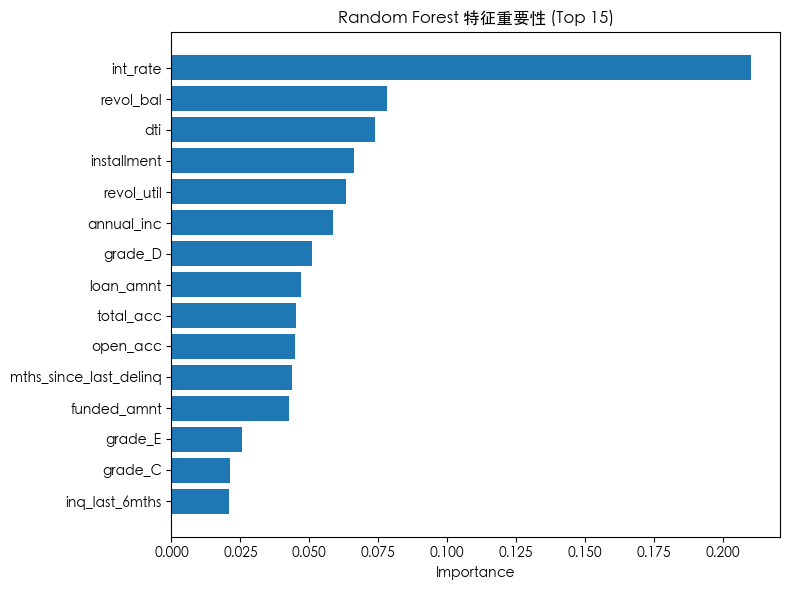

In [19]:
# 特征重要性条形图（Top 15）
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
_candidates = ["PingFang SC", "Heiti SC", "SimHei", "Microsoft YaHei", "WenQuanYi Micro Hei", "Noto Sans CJK SC", "STHeiti", "Arial Unicode MS"]
_available = {f.name for f in fm.fontManager.ttflist}
_font = next((c for c in _candidates if c in _available), None)
if _font is None:
    for _f in _available:
        if any(x in _f for x in ("CJK", "Hei", "Song", "Ming", "Kai", "Fang", "SC", "TC")):
            _font = _f
            break
if _font:
    plt.rcParams["font.sans-serif"] = [_font]
plt.rcParams["axes.unicode_minus"] = False
fig, ax = plt.subplots(figsize=(8, 6))
top_n = 15
imp_top = imp.head(top_n)
ax.barh(range(len(imp_top)), imp_top["importance"].values)
ax.set_yticks(range(len(imp_top)))
ax.set_yticklabels(imp_top["feature"].values)
ax.invert_yaxis()
ax.set_xlabel("Importance")
ax.set_title("Random Forest 特征重要性 (Top 15)")
plt.tight_layout()
plt.show()

### 5. AUC-ROC 曲线

用 AUC-ROC 曲线对比 Logistic Regression 与 Random Forest 的排序能力

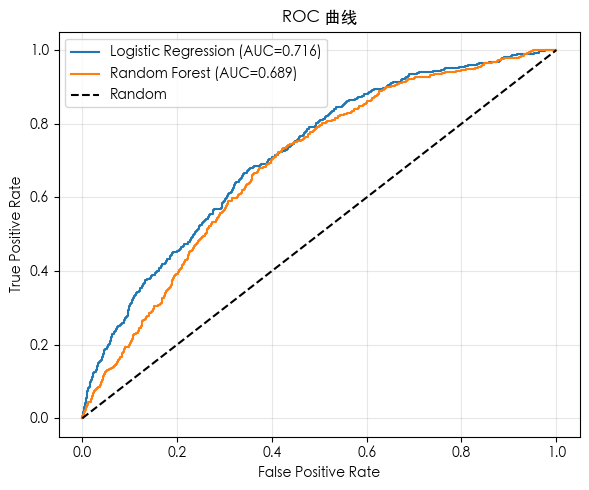

In [20]:
from sklearn.metrics import roc_curve

fig, ax = plt.subplots(figsize=(6, 5))
for name, y_proba in [("Logistic Regression", y_proba_lr), ("Random Forest", y_proba_rf)]:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    ax.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
ax.plot([0, 1], [0, 1], "k--", label="Random")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC 曲线")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

- **ROC 曲线**：横轴 FPR（误把好人判成违约的比例）、纵轴 TPR（真正违约被找出的比例）。曲线越靠近左上角，说明在相同 FPR 下 TPR 越高，排序能力越好。
- **AUC**：LR（0.716）> RF（0.689），即 LR 的曲线更靠左上角，**整体排序能力略优**；两者均明显高于随机（0.5），说明模型学到了有效信号。
- **业务选择建议**：  
  - 若更看重“少漏掉违约客户”（如反欺诈、首贷严控），可优先 **LR**（召回高、AUC 略高），再按业务成本调阈值。  
  - 若更看重“少误拒正常客户”（体验优先），可倾向 **RF**（假正例更少），或对 LR 提高分类阈值。  
